# Sample Notebook - Named Entity Recognition

Named Entity Recognition (NER) is a task in which we want to classify textual entities.

Examples of textual entities are a) words, b) sub-sentences or c) **tokens**.

**N.b.** When we classify the FULL sentence, we talk about text-classification (code slightly changes).

### If you are interested in more details, please visit:
- https://huggingface.co/learn/llm-course/chapter7/2

## Data Processing

### Load the dataset again:

In [1]:
import pandas as pd
INPUT_PATH = "CyNER_dataset"
train_df = pd.read_parquet(f"{INPUT_PATH}/train.parquet")
test_df = pd.read_parquet(f"{INPUT_PATH}/test.parquet")
print(f"Training dataset contains {train_df.shape[0]:,} elements")
print(f"Testing dataset contains {test_df.shape[0]:,} elements")

Training dataset contains 3,690 elements
Testing dataset contains 410 elements


#### Remember: this dataset contains `sentences` and `tags` (1 tag per word)

In [2]:
train_df.head(2)

,sentences,tags
0,The precautions you take online have been cove...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,This brand new malware has real potential to b...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


#### We follow the same "good" practises: before training the model, let's extract a validation set

In [3]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"New training dataset contains {train_df.shape[0]:,} elements")
print(f"Validation dataset contains {val_df.shape[0]:,} elements")

New training dataset contains 2,952 elements
Validation dataset contains 738 elements


### Usually, when working with huggingface classes, we also use their `datasets` class to handle our input

In [4]:
from datasets import Dataset, DatasetDict

In [5]:
# Convert the training DATAFRAME into an huggingface DATASET
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
train_ds

Dataset({
    features: ['sentences', 'tags'],
    num_rows: 2952
})

#### We can also keep all the partitions together
##### Doing that, all operations (e.g., tokenization) are going to be performed on ALL the partitions

In [6]:
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)), 
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)), 
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)), 
    }
)
full_ds

DatasetDict({
    train: Dataset({
        features: ['sentences', 'tags'],
        num_rows: 2952
    })
    valid: Dataset({
        features: ['sentences', 'tags'],
        num_rows: 738
    })
    test: Dataset({
        features: ['sentences', 'tags'],
        num_rows: 410
    })
})

### Notice: `tags` here are the equivalent of the `labels` we've always used in the past
#### Exactly as the labels from the other labs, we cannot keep them as strings (the algorithm needs numbers!)

In [7]:
# 1. Extract the labels
unique_labels = list(train_df.tags.explode().unique())
print(unique_labels)

['O', 'I-Indicator', 'B-Indicator', 'B-Malware', 'I-Malware', 'B-System', 'I-System', 'B-Organization', 'I-Organization', 'B-Vulnerability', 'I-Vulnerability']


In [8]:
# 2. Obtain a dictionary that maps the labels into identifiers (Labels Encoder)
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}
print(label2id)

{'O': 0, 'I-Indicator': 1, 'B-Indicator': 2, 'B-Malware': 3, 'I-Malware': 4, 'B-System': 5, 'I-System': 6, 'B-Organization': 7, 'I-Organization': 8, 'B-Vulnerability': 9, 'I-Vulnerability': 10}


#### Now that we identified the `label2id` dictionary, use the Dataset `map` function to map all `tags` into `numeric tags`!
##### Notice: it already works on ALL the partitions (`train`, `validation` and `test`)

In [9]:
def convert_labels_to_ids(sample):
    sample['tags_id'] = [label2id[el] for el in sample["tags"]]
    return sample
# Apply the mapping function to all splits of your dataset
encoded_dataset = full_ds.map(convert_labels_to_ids)
encoded_dataset

Map:   0%|          | 0/2952 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentences', 'tags', 'tags_id'],
        num_rows: 2952
    })
    valid: Dataset({
        features: ['sentences', 'tags', 'tags_id'],
        num_rows: 738
    })
    test: Dataset({
        features: ['sentences', 'tags', 'tags_id'],
        num_rows: 410
    })
})

In [10]:
print("Example:")
EXAMPLE_ID = 3
print(f'Original tags: {encoded_dataset["train"][EXAMPLE_ID]["tags"]}')
print(f'Converted tags: {encoded_dataset["train"][EXAMPLE_ID]["tags_id"]}')

Example:
Original tags: ['I-Indicator', 'I-Indicator', 'O', 'B-Indicator', 'I-Indicator', 'I-Indicator', 'I-Indicator', 'I-Indicator']
Converted tags: [1, 1, 0, 2, 1, 1, 1, 1]


### Now, let's proceed with the tokenization!

In [11]:
from transformers import AutoTokenizer
model = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

#### ATTENTION: When we tokenize the sentences, we transform words into tokens > losing 1vs1 relationship with tags!

In [12]:
print("Example:")
sample = full_ds["train"][5]
n_words = len(sample['sentences'].split())
n_tags = len(sample["tags"])
print(f"\tOriginal sentence contains {n_words} words and is associated with {n_tags} tags")
tokenized_sentence = tokenizer(sample['sentences'])
print(f"\tHowever, after tokenization, we have {len(tokenized_sentence['input_ids'])} tokens!")

Example:
	Original sentence contains 8 words and is associated with 8 tags
	However, after tokenization, we have 16 tokens!


#### Ideally, we would like to "expand" the words' tags to the corresponding tokens > Let's use the `word_ids`!

In [13]:
# Remember: we need to `add add_prefix_space` and tell the tokenizer sentences are already split!
tokenizer = AutoTokenizer.from_pretrained(model, add_prefix_space=True)
splitted_sentence = sample['sentences'].split()
tokenized_sentence = tokenizer(splitted_sentence, is_split_into_words=True)

#### Now we can map how each tag relates to the single tokens!

In [14]:
print(f"Specifically:")
# Extract the words_ids and the input_ids
word_ids = tokenized_sentence.word_ids()
input_ids = tokenized_sentence.input_ids
# Also get the sample tags
tags = sample['tags']

for word_id, input_id in zip(word_ids, input_ids):
    if word_id is not None: # One associated to <CLS> or <EOS>
        token = tokenizer.convert_ids_to_tokens(input_id)
        print(f"\t - Token {token} belongs to word {splitted_sentence[word_id]} and is associated to the tag {tags[word_id]}")

Specifically:
	 - Token the belongs to word The and is associated to the tag O
	 - Token main belongs to word main and is associated to the tag O
	 - Token dl belongs to word DLL and is associated to the tag O
	 - Token ##l belongs to word DLL and is associated to the tag O
	 - Token is belongs to word is and is associated to the tag O
	 - Token called belongs to word called and is associated to the tag O
	 - Token " belongs to word " and is associated to the tag O
	 - Token re belongs to word Reznov.DLL and is associated to the tag B-Indicator
	 - Token ##z belongs to word Reznov.DLL and is associated to the tag B-Indicator
	 - Token ##nov belongs to word Reznov.DLL and is associated to the tag B-Indicator
	 - Token . belongs to word Reznov.DLL and is associated to the tag B-Indicator
	 - Token dl belongs to word Reznov.DLL and is associated to the tag B-Indicator
	 - Token ##l belongs to word Reznov.DLL and is associated to the tag B-Indicator
	 - Token . belongs to word . and is ass

### We can do that systematically for the entire dataset!

#### Create a function that aligns the labels with the tokens

In [15]:
def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text.

    This function maps word-level labels to their corresponding tokens after tokenization.
    It handles special tokens (with None word_ids) and subword tokens (multiple tokens for one word).
    Args:
       labels (list): Original word-level labels.
       word_ids (list): List of word indices that each token corresponds to.
                        None values represent special tokens.
    Returns:
       list: New token-aligned labels where:
            - Special tokens (None word_ids) are assigned -100
            - First token of each word gets the word's label
            - Continuation tokens of the same word also get the word's label
    Example:
       labels = [0, 1, 2]  # Labels for 3 words
       word_ids = [None, 0, 0, 1, 2, 2, None]  # Tokenized into 7 tokens
       result = [-100, 0, 0, 1, 2, 2, -100]  # Aligned labels
    """
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

#### Now create a function that, for each sample:
1) Tokenize the input
2) Align the tokens with the corresponding tags

In [16]:
def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens.
    This function processes a batch of examples by:
    1. Tokenizing the text in 'sentences' field
    2. Converting word-level labels to token-level labels for each example
    3. Adding the aligned labels back to the tokenized inputs
    Args:
       examples (dict): Dictionary containing:
           - 'sentences': List of text sentences
           - 'tags_id': List of lists containing word-level tags for each command
    Returns:
       dict: Tokenized inputs with aligned labels:
           - Standard tokenizer outputs (input_ids, attention_mask, etc.)
           - 'labels': Token-level labels aligned with the tokenized inputs
    Notes:
       - Uses a pre-defined tokenizer (must be available in scope)
       - Sets is_split_into_words=True because input is already word-tokenized
       - Uses align_labels_with_tokens helper function to handle subword tokenization
    """
    # Remember: we need to split the sentences 
    split_sentences = [sentence.split() for sentence in samples["sentences"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences, 
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True  # Input is already split into words
    )
    # Extract all tags_id lists from the examples
    all_tags = samples["tags_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

#### Eventually, use the `map` function provided by the huggingface Dataset 
##### Notice: it already works on ALL the partitions (`train`, `validation` and `test`)

In [17]:
original_columns = encoded_dataset["train"].column_names
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
tokenized_datasets

Map:   0%|          | 0/2952 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2952
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 738
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 410
    })
})

In [18]:
EXAMPLE_ID = 5
print(f"EXAMPLE) Given the sentence: '{encoded_dataset['train'][EXAMPLE_ID]['sentences']}'")
example = tokenized_datasets["train"][EXAMPLE_ID]
print(f'Tokens ({len(example["input_ids"])} elements): {[tokenizer.convert_ids_to_tokens(input_id) for input_id in example["input_ids"]]}')
print(f'Tags ({len(example["labels"])} elements): {example["labels"]}')

EXAMPLE) Given the sentence: 'The main DLL is called " Reznov.DLL .'
Tokens (16 elements): ['[CLS]', 'the', 'main', 'dl', '##l', 'is', 'called', '"', 're', '##z', '##nov', '.', 'dl', '##l', '.', '[SEP]']
Tags (16 elements): [-100, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, -100]


### We still have one problem: all sentences have a different number of input_ids!
#### Remember: to create batches, we need that all elements withing the same batch have the same number of `columns`!

### Huggingface provides ad-hoc DataCollators, depending on the task we are solving!
- https://huggingface.co/docs/transformers/en/main_classes/data_collator#data-collator
#### In this case, we are interested on the `DataCollatorForTokenClassification`

In [19]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

#### The DataCollatorForTokenClassification pad both input_ids and labels belonging to the same batch!

In [20]:
print("Example BEFORE the data collator:")
for i in range(2):
    print(f"\nSentence {i}:")
    input_id, label = tokenized_datasets["train"][i]["input_ids"], tokenized_datasets["train"][i]["labels"]
    print(f"\tInput ids (len={len(input_id)}):", end="\t")
    print(input_id)   
    print(f"\tLabels: (len={len(label)})", end="\t")
    print(label)

Example BEFORE the data collator:

Sentence 0:
	Input ids (len=17):	[101, 2057, 2988, 1996, 18726, 2000, 1996, 8224, 3036, 2136, 1998, 2027, 2020, 12128, 3718, 1012, 102]
	Labels: (len=17)	[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]

Sentence 1:
	Input ids (len=8):	[101, 1033, 16571, 12789, 3490, 1031, 1012, 102]
	Labels: (len=8)	[-100, 1, 1, 1, 1, 2, 1, -100]


In [21]:
# Creating a batch with 2 elements as a proof of concept
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
input_ids, labels = batch["input_ids"], batch["labels"]
print("Example AFTER the data collator:")
for i in range(2):
    print(f"\nSentence {i}:")
    input_id, label = input_ids[i], labels[i]
    print(f"\tInput ids (len={len(input_id)}):", end="\t")
    print(input_id)   
    print(f"\tLabels (len={len(label)}):", end="\t")
    print(label)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Example AFTER the data collator:

Sentence 0:
	Input ids (len=17):	tensor([  101,  2057,  2988,  1996, 18726,  2000,  1996,  8224,  3036,  2136,
         1998,  2027,  2020, 12128,  3718,  1012,   102])
	Labels (len=17):	tensor([-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, -100])

Sentence 1:
	Input ids (len=17):	tensor([  101,  1033, 16571, 12789,  3490,  1031,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0])
	Labels (len=17):	tensor([-100,    1,    1,    1,    1,    2,    1, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100])


### Now we are finally ready to create the dataloaders!

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

## Fine-Tuning a pre-trained model

### Huggingface provide a collection of pre-trained model one could load:
- https://huggingface.co/models

#### As we performed the tokenization with `google-bert/bert-base-uncased`, we keep using this model!

In [23]:
pretrained_model = "google-bert/bert-base-uncased"

#### Notice that this is original BERT model from `https://arxiv.org/abs/1810.04805`!
##### We can load the "empty model" (just the layers, weights are going to be randomly initialized):

In [24]:
from transformers import AutoModelForTokenClassification, AutoConfig
# First, get the configuration of the model
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label, # Notice that we are also providing the mapping from ids to labels
    label2id=label2id, # And viceversa
)
# Then initialize the model with random weights using the configuration
model = AutoModelForTokenClassification.from_config(config)
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

#### However, as we want to leverage the "power" of pre-training, we are interested in the model + weights!
##### To load them, simply:

In [25]:
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at

#### What happens behind the curtains:
- Script checks if the `pretrained_model` is a path corresponding to an existing directory in the local pc
- If it cannot find it, it queries `https://huggingface.co/models` and download the models locally

**Notice**: in the case above a warning tells us that we just loaded the pre-trained encoder, while the last layers are still not trained!

**This makes totally sense**: BERT was pre-trained with Masked Language Modelling, while it's up to us to train the classification head!

### From now on, it's the same usual training pipeline 
#### Just, we did not define a model because somebody already make it for us!

##### Define training parameters

In [26]:
from torch.optim import AdamW
# Notice: model has already been pre-trained. 
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small! 
LR = 5e-6
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

In [27]:
from transformers import get_scheduler
# Usually Transformers architectures are trained with a linear scheduler
# This means that the LR is linearly scaled down at every training step

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

##### Remember: the model is going to classify all tokens > we need a function to post-process and gather the predictions!

In [28]:
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.

    This function detaches predictions and labels from any computation graph,
    moves them to CPU, clones, and converts them to NumPy arrays. It then
    maps token IDs to their corresponding label names, ignoring special
    tokens indicated by the index `-100`.

    Args:
        predictions (torch.Tensor): Model output predictions (logits or token IDs).
        labels (torch.Tensor): Ground-truth labels corresponding to the inputs.

    Returns:
        Tuple[List[List[str]], List[List[str]]]: 
            A tuple containing two lists:
            - `true_predictions`: The list of predicted label sequences, aligned with the true labels.
            - `true_labels`: The list of true label sequences with special tokens removed.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

##### Define metrics and a function named `compute_metrics` 

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np 

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    Args:
        full_predictions: List of lists of predicted labels
        full_labels: List of lists of true labels  
    Returns:
        dict: Dictionary containing calculated metrics
    """
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    } 
    return metrics

##### Initialize some variable to keep track of the best model during training

In [30]:
from copy import deepcopy 
# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

##### Optionally, move everything to GPU if it's defined

In [31]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
model.device

device(type='cuda', index=0)

##### Eventually, run the training loop!

In [32]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], 
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        ) 
        # Notice: the model already comes with a CrossEntropy loss 
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)   
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

  0%|          | 0/9250 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.8875636132315522, 'token_f1': 0.18513681553679423}
epoch 1: {'token_accuracy': 0.915632951653944, 'token_f1': 0.3087957971801066}
epoch 2: {'token_accuracy': 0.9347964376590331, 'token_f1': 0.3464801182028314}
epoch 3: {'token_accuracy': 0.9450540712468194, 'token_f1': 0.45103956595333483}
epoch 4: {'token_accuracy': 0.9542779898218829, 'token_f1': 0.525672526252593}
epoch 5: {'token_accuracy': 0.9576176844783715, 'token_f1': 0.5582154060225437}
epoch 6: {'token_accuracy': 0.9602417302798982, 'token_f1': 0.6195384477877206}
epoch 7: {'token_accuracy': 0.9633428753180662, 'token_f1': 0.6812108540537415}
epoch 8: {'token_accuracy': 0.9627465012722646, 'token_f1': 0.6700317089897235}
epoch 9: {'token_accuracy': 0.9642573155216285, 'token_f1': 0.7095625725599316}
epoch 10: {'token_accuracy': 0.964416348600509, 'token_f1': 0.7107196091084682}
epoch 11: {'token_accuracy': 0.9656488549618321, 'token_f1': 0.7246150220052745}
epoch 12: {'token_accuracy': 0.96711991

#### Plot losses after the training loop

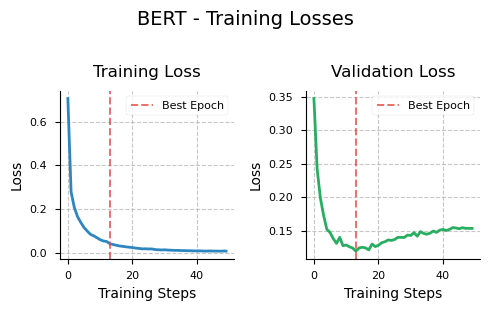

In [33]:
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)
    
    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses, 
           validation_losses=val_losses, best_epoch=best_epoch)

### After training, move to the test phase!

In [34]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)   

In [35]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  96.48%
token_f1            :  76.31%
token_precision     :  81.01%
token_recall        :  73.33%


#### Also plot the confusion matrix

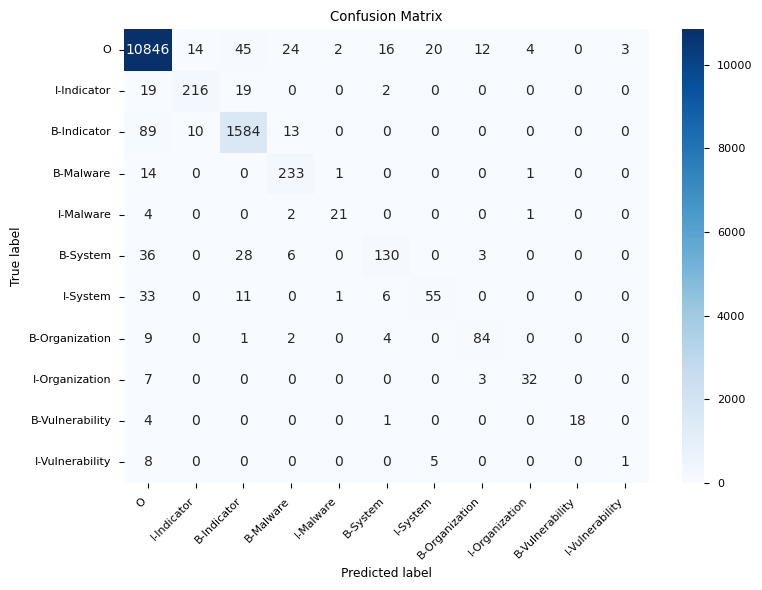

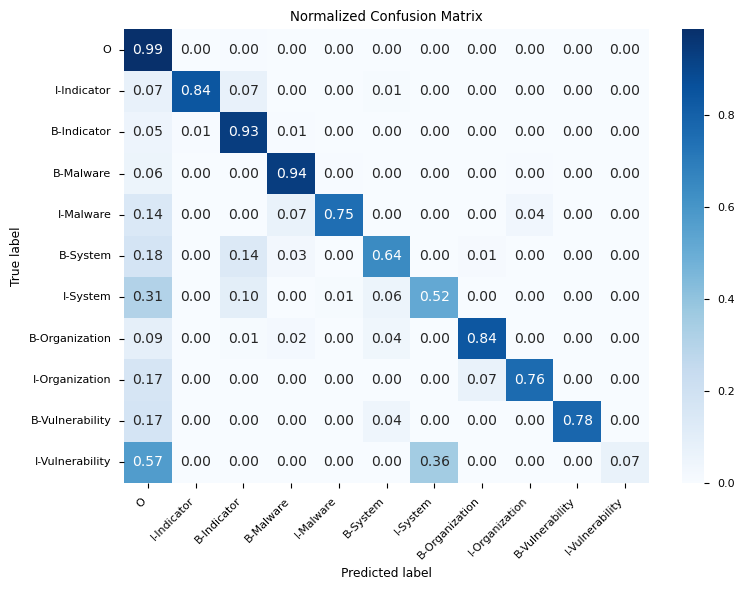

array([[9.87256508e-01, 1.27434917e-03, 4.09612234e-03, 2.18459858e-03,
        1.82049882e-04, 1.45639905e-03, 1.82049882e-03, 1.09229929e-03,
        3.64099763e-04, 0.00000000e+00, 2.73074823e-04],
       [7.42187500e-02, 8.43750000e-01, 7.42187500e-02, 0.00000000e+00,
        0.00000000e+00, 7.81250000e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.24764151e-02, 5.89622642e-03, 9.33962264e-01, 7.66509434e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.62248996e-02, 0.00000000e+00, 0.00000000e+00, 9.35742972e-01,
        4.01606426e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.01606426e-03, 0.00000000e+00, 0.00000000e+00],
       [1.42857143e-01, 0.00000000e+00, 0.00000000e+00, 7.14285714e-02,
        7.50000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.57142857e-02, 0.00000000e+00, 0.00000000e+

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)